# Preparación para el PF MDS+

## Exploración de los datos (EDA)

Repo para trabajo de preparación

Dataset: https://www.yelp.com/dataset/documentation/main

Extraer fotos del RAR en /dataset/photos.

Extraer archivo photos.json en /dataset

In [10]:
import pandas as pd
import pathlib
# pip install imageio==2.21.1
import imageio as iio
import numpy as np
import matplotlib.pyplot as plt
# pip install scikit-image==0.19.3
from skimage.color import rgb2gray
import os
from matplotlib import image
import pickle
from sklearn.preprocessing import OneHotEncoder

## EDA del JSON

In [11]:
%%time
df = pd.read_json(r'dataset/photos.json', lines=True)

CPU times: user 419 ms, sys: 103 ms, total: 521 ms
Wall time: 686 ms


In [12]:
df.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food


No vamos usar 'business_id' ni 'caption' en el trabajo

In [13]:
df = df.drop(columns = ['business_id', 'caption'])
df.head(2)

,photo_id,label
0,zsvj7vloL4L5jhYyPIuVwg,inside
1,HCUdRJHHm_e0OCTlZetGLg,outside


In [14]:
df.shape

(200100, 2)

In [15]:
df.describe()

,photo_id,label
count,200100,200100
unique,200098,5
top,_CYoxbCIKuAwpq4crHCPWg,food
freq,2,108152


In [16]:
df.label.value_counts()

food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: label, dtype: int64

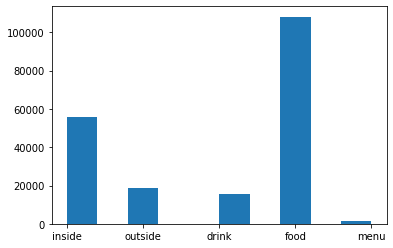

In [17]:
plt.hist(df.label);

Hay pocas fotos de 'menu'

In [18]:
df.photo_id.value_counts().max()

2

Hay fotos con dos etiquetas (labels)

In [19]:
df.photo_id.value_counts().nlargest(n=3)

_CYoxbCIKuAwpq4crHCPWg    2
qtl5YDIc2q0yelW_e9FfqQ    2
zsvj7vloL4L5jhYyPIuVwg    1
Name: photo_id, dtype: int64

Solo hay dos fotos que tienen dos etiquetas.

In [20]:
df[df.photo_id == '_CYoxbCIKuAwpq4crHCPWg']

,photo_id,label
29695,_CYoxbCIKuAwpq4crHCPWg,inside
174504,_CYoxbCIKuAwpq4crHCPWg,drink


In [21]:
df[df.photo_id == 'qtl5YDIc2q0yelW_e9FfqQ']

,photo_id,label
173977,qtl5YDIc2q0yelW_e9FfqQ,inside
188850,qtl5YDIc2q0yelW_e9FfqQ,food


## EDA de las fotos

In [ ]:
%%time
img_path = 'dataset/photos/'
lista = os.listdir(img_path)

In [ ]:
lista.to_pickle('lista.pkl')

In [ ]:
# checkpoint
lista = pd.read_pickle('lista.pkl')

In [ ]:
df.head()

In [ ]:
example_photo_name = lista[0]
example_photo_index = df[df.photo_id == example_photo_name[:-4]].index[0]
im = iio.v3.imread('dataset/photos/'+example_photo_name)

In [ ]:
im.shape

In [ ]:
plt.imshow(im);
print('Photo: {}   Tag: {}'.format(example_photo_name,
                                   df.loc[df.photo_id == example_photo_name[:-4],
                                          'label'][example_photo_index]))

In [ ]:
# Convertir en gris
im_gray = rgb2gray(im)

In [ ]:
im_gray.shape

In [ ]:
plt.imshow(im_gray, cmap='gray', interpolation='nearest');
print('Photo: {}   Tag: {}'.format(example_photo_name, 
                                   df.loc[df.photo_id == example_photo_name[:-4], 
                                          'label'][example_photo_index]))

Convertir en gris reduce la información a procesar a un tercio. Si el coste de entrenar el modelo es muy alto, se probará con la versión gris de las imagenes.

Vamos comprobar si las imagenes tienen distintos tamaños y si son todas validas.

In [ ]:
%%time
#import time
from progress.bar import Bar
bar = Bar('Processing photos', fill='#', suffix='%(percent)d%%', max=20)

photo_counter = 0
#start_time = time.time()
photo_data =[]
for img in df.photo_id:
    try:
        shape = image.imread(img_path+img).shape
        photo_data.append([img[:-4],     # photo_id sin extensión '.jpg'
                    shape[0],            # x_dim
                    shape[1],            # y_dim
                    shape[2],            # z_channels
                    shape[0] * shape[1], # size
                    False])              # corrupt
    except:
        # file is corrupt
        photo_data.append([img[:-4],    # photo_id sin extensión '.jpg'
                           np.nan,      # x_dim
                           np.nan,      # y_dim
                           np.nan,      # z_channels
                           np.nan,      # size
                           True])       # corrupt
    photo_counter +=1
    if photo_counter % 1000 == 0:
        bar.next()
        #print('Processed {}k photos in {:0.1f} seconds'.format(photo_counter // 1000, time.time() - start_time))
        #start_time = time.time()
bar.finish()

In [ ]:
df2 = pd.DataFrame(photo_data, columns=['photo_id', 'x_dim', 'y_dim', 'z_channels', 'size', 'corrupt'])

In [ ]:
df2.head()

In [ ]:
pickle.dump(df2, open("df2.pkl", "wb"))

In [ ]:
# df2 = pickle.load(open('df2.pkl','rb'))

In [ ]:
df2.corrupt.value_counts()

Hay 106 imagenes corruptas.

In [ ]:
df2.head()

In [ ]:
print('El dataset tiene {} imagenes validas y {} imagenes corruptas.'.format(len(df2[df2.corrupt == False]),len(df2[df2.corrupt == True])))
print('El tamaño de las imagenes en el eje x está entre {} y {} pixeles'.format(df2.x_dim.min(),df2.x_dim.max()))
print('El tamaño de las imagenes en el eje y está entre {} y {} pixeles'.format(df2.y_dim.min(),df2.y_dim.max()))
print('El número de canales está entre {} y {}'.format(df2.z_channels.min(),df2.z_channels.max()))
print('La resolución de las imagenes varia entre {} y {} miles de pixels'.format(df2.pixels.min()/1000, df2.pixels.max()/1000))

Vamos crear un dataframe que tenga las etiquetas y los datos de las imagenes.

In [ ]:
df3 = df.set_index('photo_id').join(df2.set_index('photo_id'), how="inner")#.drop('index', axis=1)

In [ ]:
df3.head()

In [ ]:
pickle.dump(df3, open("df3.pkl", "wb"))

In [ ]:
# df3 = pickle.load(open('df3.pkl','rb'))

Vamos analizar de la distribución de fotos por tipo.

In [ ]:
enc = OneHotEncoder(sparse=False, drop=None)
enc.fit(df3[['label']])
df4 = df3.copy()
df4 = df4.reset_index()
df4[enc.categories_[0]] = pd.DataFrame(enc.transform(df4[['label']]))
df4.head()

In [ ]:
pickle.dump(df4, open('df4.pkl','wb'))

In [ ]:
# df4 = pickle.load(open('df4.pkl','rb'))

In [ ]:
plt.hist(df4[['drink', 'food', 'inside', 'menu', 'outside']]);

Miremos la foto mas grande.

In [ ]:
largest_photo = df4.iloc[df4.loc[df4.pixels == df4.pixels.max()].index[0],0]
im = iio.v3.imread('dataset/photos/'+largest_photo+'.jpg')
plt.imshow(im);
df4.iloc[df4.loc[df4.pixels == df4.pixels.max()].index[0], 0:6]

...y la mas pequeña.

In [ ]:
smallest_photo = df4.iloc[df4.loc[df4.pixels == df4.pixels.min()].index[0],0]
im = iio.v3.imread('dataset/photos/'+smallest_photo+'.jpg')
plt.imshow(im);
df4.iloc[df4.loc[df4.pixels == df4.pixels.min()].index[0], 0:6]

Miremos la distribución de las fotos en función de su tamaño.

In [ ]:
plt.hist(df4.pixels.dropna(), bins=240, cumulative=True);

Hay relativamente pocas fotos con menos de 100 mil pixeles.

Miremos si eso también se aplica para cada label.

In [ ]:
df_drink = df4.loc[(df4.drink == 1.0) & (df4.corrupt == False)].pixels
df_food = df4.loc[(df4.food == 1.0) & (df4.corrupt == False)].pixels
df_inside = df4.loc[(df4.inside == 1.0) & (df4.corrupt == False)].pixels
df_menu = df4.loc[(df4.menu == 1.0) & (df4.corrupt == False)].pixels
df_outside = df4.loc[(df4.outside == 1.0) & (df4.corrupt == False)].pixels

In [ ]:
plt.hist([df_drink, df_food, df_inside, df_menu, df_outside], cumulative=True);

No parece haber problema si no usamos las fotos que tengan menos de 100k pixeles.

In [ ]:
len(df_menu.loc[df_menu > 100000])

# Conclusiones

1. Hay 199.992 fotos validas
    - food = 108.152
    - inside = 56.031
    - outside = 18.569
    - drink = 15.670
    - menu = 1.678
2. Todas las imagenes son en color (tienen 3 canales)
3. Practicamente todas las fotos tienen solo una etiqueta
4. La llave se llama 'photo_id' y no tiene extensión
5. Las imagenes tienen distintos tamaños.
     - En vertical varian entre 62 y 400 pixeles
     - En horizontal varian entre 49 y 600 pixeles
6. Hay un número significativo de fotos para todas las etiquetas si solo se usan imagenes con más de 100k pixeles (menu pasaría de 1.678 a 1.495 imagenes)